In [24]:
import shutil
import math
import numpy as np
import matplotlib.pyplot as plt
import shapely
import pyproj
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.warp
%matplotlib inline

In [2]:
src_srtm = rasterio.open('data/srtm.tif')
src_nlcd = rasterio.open('data/nlcd.tif')
zion = gpd.read_file('data/zion.gpkg')
world = gpd.read_file('data/world.gpkg')
cycle_hire_osm = gpd.read_file('data/cycle_hire_osm.gpkg')

### Querying CRS Information


In [7]:
# Finding the WKT for a crs
crs = pyproj.CRS.from_string('ESRI:54030')
print(crs.to_wkt(pretty=True))

PROJCRS["World_Robinson",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["Degree",0.0174532925199433]]],
    CONVERSION["World_Robinson",
        METHOD["Robinson"],
        PARAMETER["Longitude of natural origin",0,
            ANGLEUNIT["Degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["False easting",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["(E)",east,
            ORDER[1],
            LENGTHUNIT["metre",1]],
        AXIS["(N)",north,
            ORDER[2],
            LENGTHUNIT["metre",1]],
    USAGE[
        SCOPE["Not known."],
        AREA["World."],
        BBOX[-90,-180,90,180]],
    ID["ESRI",54030]]


In [3]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
print(world.crs.is_geographic)
world.crs.axis_info[0].unit_name, world.crs.axis_info[1].unit_name

True


('degree', 'degree')

In [6]:
world.crs.to_authority()

('EPSG', '4326')

### Reprojecting CRS

In Geopandas:

set_crs() only updates the metadata, and does not change the actual units.

to_crs() transforms the units in the GeoDataFrame

It is important that 
* Geometric calculations are only applied in projected CRS. This because geographic crs are in degrees, which are not constant throughout the Earth's surface. 
* If there is more than one layer involved—all layers have to be in the same (projected) CRS
* Distance and area values, are passed, and returned, in CRS units


In [14]:
# changing the crs of a raster
dst_crs = 'EPSG:4326'

print(src_nlcd.shape, src_nlcd.crs)

# This method preserves as much of the original raster as possible
dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
    src_nlcd.crs,
    dst_crs,
    src_nlcd.width,
    src_nlcd.height,
    *src_nlcd.bounds)

print(dst_transform)
print(f"transformed ({dst_crs}) shape: {dst_width, dst_height}")

(1359, 1073) EPSG:26912
| 0.00, 0.00,-113.24|
| 0.00,-0.00, 37.52|
| 0.00, 0.00, 1.00|
transformed (EPSG:4326) shape: (1244, 1246)


In [15]:
# Also need to update the metadata file
dst_kwargs = src_nlcd.meta.copy()
dst_kwargs.update({
    'crs': dst_crs,
    'transform': dst_transform,
    'width': dst_width,
    'height': dst_height
})
dst_kwargs


{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 1244,
 'height': 1246,
 'count': 1,
 'crs': 'EPSG:4326',
 'transform': Affine(0.0003150631685351472, 0.0, -113.24138811813536,
        0.0, -0.0003150631685351472, 37.51912722777022)}

In [16]:
dst_nlcd = rasterio.open('output/nlcd_4326.tif', 'w', **dst_kwargs)

rasterio.warp.reproject(
    source=rasterio.band(src_nlcd, 1),
    destination=rasterio.band(dst_nlcd, 1),
    src_transform=src_nlcd.transform,
    src_crs=src_nlcd.crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=rasterio.enums.Resampling.nearest)

dst_nlcd.close()

In [17]:
src_nlcd.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 1073,
 'height': 1359,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["NAD83 / UTM zone 12N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26912"]]'),
 'transform': Affine(31.530298224786595, 0.0, 301903.344386758,
        0.0, -31.52465870178793, 4154086.47216415)}

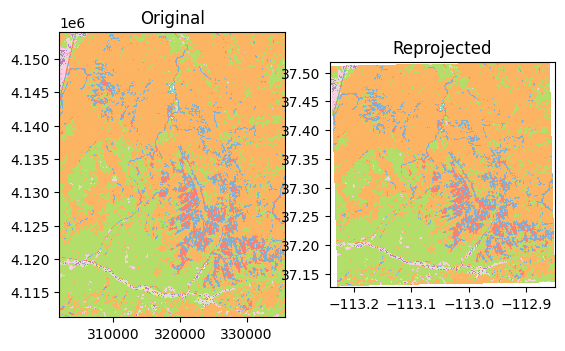

In [20]:
src_nlcd_4326 = rasterio.open('output/nlcd_4326.tif')

fig, ax = plt.subplots(1, 2)
rasterio.plot.show(src_nlcd, cmap='Set3', ax = ax[0])
rasterio.plot.show(src_nlcd_4326, cmap='Set3', ax = ax[1])
ax[0].set_title('Original')
ax[1].set_title('Reprojected')
plt.show()

In [ ]:
# Can also use a template for the reprojection, e.g to more closely match other layers
template = rasterio.open('output/nlcd_4326.tif')
dst_nlcd_2 = rasterio.open('output/nlcd_4326_2.tif', 'w', **template.meta)

rasterio.warp.reproject(
    source=rasterio.band(src_nlcd, 1),
    destination=rasterio.band(dst_nlcd_2, 1),
    src_transform=src_nlcd.transform,
    src_crs=src_nlcd.crs,
    dst_transform=dst_nlcd_2.transform,
    dst_crs=dst_nlcd_2.crs,
    resampling=rasterio.enums.Resampling.nearest)

# This file is identical the one we created in the previous cell
dst_nlcd_2.close()

### Custom Reprojection

In [21]:
lon, lat = zion.to_crs(4326).union_all().centroid.coords[0]

custom_wkt = f'''PROJCS["Custom_AEQD",
 GEOGCS["GCS_WGS_1984",
  DATUM["WGS_1984",
   SPHEROID["WGS_1984",6378137.0,298.257223563]],
  PRIMEM["Greenwich",0.0],
  UNIT["Degree",0.0174532925199433]],
 PROJECTION["Azimuthal_Equidistant"],
 PARAMETER["Central_Meridian",{lon}],
 PARAMETER["Latitude_Of_Origin",{lat}],
 UNIT["Meter",1.0]]'''

zion_aeqd = zion.to_crs(custom_wkt)

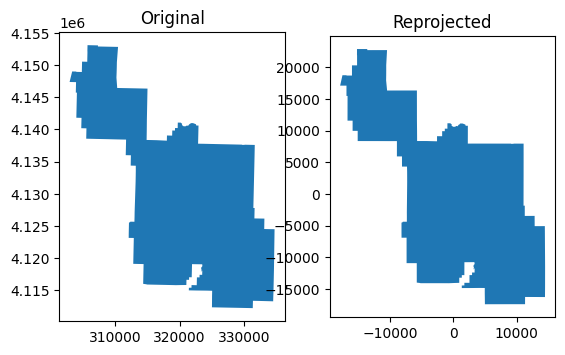

In [23]:
fig, ax = plt.subplots(1, 2)
zion.plot(ax = ax[0])
zion_aeqd.plot(ax = ax[1])
ax[0].set_title('Original')
ax[1].set_title('Reprojected')
plt.show()